In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders
from sklearn.metrics import classification_report, confusion_matrix

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19


2022-12-27 14:51:01.718686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 14:51:02.950842: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/cv2/../../../../lib::/home/ines/anaconda3/envs/tf/lib/
2022-12-27 14:51:02.950929: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ines/anacond

# Dataset Loading and Splitting



In [2]:
base_ds = '/home/ines/Downloads/Rice_Image_Dataset(2)/Rice_Image_Dataset'
base_ds = pathlib.Path(base_ds)

In [3]:
base_ds

PosixPath('/home/ines/Downloads/Rice_Image_Dataset(2)/Rice_Image_Dataset')

In [4]:
#split imgs
import splitfolders
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)

In [5]:
#listdir returns everything in directory
arborio = [fn for fn in os.listdir(f'{base_ds}/Arborio') if fn.endswith('.jpg')]
bastmati = [fn for fn in os.listdir(f'{base_ds}/Basmati') if fn.endswith('.jpg')]
ipsala = [fn for fn in os.listdir(f'{base_ds}/Ipsala') if fn.endswith('.jpg')]
jasmine = [fn for fn in os.listdir(f'{base_ds}/Jasmine') if fn.endswith('.jpg')]
karacadag = [fn for fn in os.listdir(f'{base_ds}/Karacadag') if fn.endswith('.jpg')]
rice = [arborio, bastmati, ipsala, jasmine, karacadag]
rice_classes = []
for i in os.listdir('imgs/train'):
    rice_classes+=[i]
rice_classes.sort()

# Dataset Exploration

In [16]:
arborio = list(base_ds.glob('Arborio/*'))[:600]
basmati = list(base_ds.glob('Basmati/*'))[:600]
ipsala = list(base_ds.glob('Ipsala/*'))[:600]
jasmine = list(base_ds.glob('Jasmine/*'))[:600]
karacadag = list(base_ds.glob('Karacadag/*'))[:600]

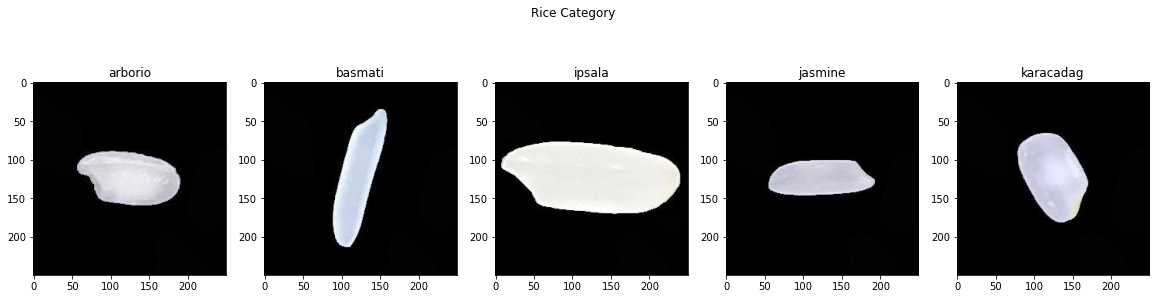

In [17]:
import matplotlib.image as img
fig, ax = plt.subplots(ncols=5, figsize=(20,5))
fig.suptitle('Rice Category')
arborio_img = img.imread(arborio[0])
basmati_img = img.imread(basmati[0])
ipsala_img = img.imread(ipsala[0])
jasmine_img = img.imread(jasmine[0])
karacadag_img = img.imread(karacadag[0])

ax[0].set_title('arborio')
ax[1].set_title('basmati')
ax[2].set_title('ipsala')
ax[3].set_title('jasmine')
ax[4].set_title('karacadag')


ax[0].imshow(arborio_img)
ax[1].imshow(basmati_img)
ax[2].imshow(ipsala_img)
ax[3].imshow(jasmine_img)
ax[4].imshow(karacadag_img)

In [25]:
#batch size = 100: takes from 1st to 100th sample in training and trains, then 101st to 200th..
#if training not divisible by batch without remainder, set batch to 100+remainder
#batch < pop: requires less memory
#types like in gd
batch_size = 32
img_height, img_width =  224, 224
input_shape = (img_height, img_width, 3)



# Data Pre-processing

In [26]:
#data aug: techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting 
#Generate batches of tensor image data with real-time data augmentation
#rescale: data * value
#validation data should not be augmented
datagen = ImageDataGenerator(rescale=1./255)

In [27]:
#flow from dir when train_ds test_ds and val_ds
train_ds = datagen.flow_from_directory(
    #dir
    'imgs/train',
    #resize
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    #binary labels for categorical_crossentropy loss
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 54003 images belonging to 7 classes.
Found 11571 images belonging to 7 classes.
Found 11574 images belonging to 7 classes.


In [34]:
data_images = {
    'arborio' : arborio,
    'basmati' : basmati,
    'ipsala' : ipsala,
    'jasmine' : jasmine,
    'karacadag': karacadag
}

# Contains numerical labels for the categories
data_labels = {
    'arborio' : 0,
    'basmati' : 1,
    'ipsala' : 2,
    'jasmine' : 3,
    'karacadag': 4
}

In [35]:
X, y = [], [] # X = images, y = labels
for label, images in data_images.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224)) # Resizing the images to be able to pass on MobileNetv2 model
        X.append(resized_img) 
        y.append(data_labels[label])

In [37]:


X = np.array(X)
X = X/255
y = np.array(y)



In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val)

# Transfer Learning

In [39]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=input_shape)

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(tf.keras.layers.Dense(10, activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 10)                250890    
                                                                 
Total params: 20,275,274
Trainable params: 250,890
Non-trainable params: 20,024,384
_________________________________________________________________


In [40]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [41]:

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 32),
 validation_data = (te, testY), steps_per_epoch = len(trainX) // 32,
 epochs = 10)

/tmp/ipykernel_4948/4082123093.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_ds,


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_4948/4082123093.py", line 1, in <cell line: 1>
      history = model.fit_generator(generator=train_ds,
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 2604, in fit_generator
      return self.fit(
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1024, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1082, in compute_loss
      return self.compiled_loss(
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 2004, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/backend.py", line 5538, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[32,10] labels_size=[32,7]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_4829]